# **Предсказание популярности новостей**

# 0. Импорт необходимых библиотек и чтение данных из готового файла csv.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

In [2]:
from google.colab import drive, output
output.clear()
drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/News_popularity/'
output.clear()

In [3]:
df= pd.read_csv(drive_data_path+"News_Final.csv")
print(len(df))
df.tail()

93230


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
93225,61851.0,Stocks rise as investors key in on US economy ...,The June employment report is viewed as a cruc...,MarketWatch,economy,2016-07-07 15:31:05,0.104284,0.044943,-1,3,5
93226,61865.0,Russian PM proposes to use conservative and to...,"In addition, establish stimulating economic po...",TASS,economy,2016-07-07 15:31:10,0.072194,0.000000,-1,0,1
93227,104793.0,Palestinian Government Uses Foreign Aid To Pay...,The Palestinian government spends nearly $140 ...,Daily Caller,palestine,2016-07-07 15:38:26,0.291667,-0.139754,9,1,0
93228,104794.0,Palestine Youth Orchestra prepares for first U...,Palestine Youth Orchestra prepares for first U...,Ahram Online,palestine,2016-07-07 15:59:22,0.121534,0.092313,1,0,0
93229,61870.0,Sausalito businesswoman wins $10000 in Microso...,"Goldstein, the proprietor of the TG Travel Gro...",East Bay Times,microsoft,2016-07-07 16:16:11,0.000000,0.054554,-1,1,0


# 1. Предобаботка данных.

**а) проверка на наличие пропущенных значений и их удаление**

*Строки с пропущенными значениями - NaN - можно как выбрасывать, так оставлять, заполняя пропущенное поле средним значением по классу или приблизительному интервалу. Всегда лучше оставлять данные, особенно если количество пропусков довольно большое или эти строки играют важную роль для обучения модели. В данном случае количество пропусков очень маленькое, тем более пропущены главные признаки, которые заменить нельзя, поэтому без сожаления выбрасываем.*

In [4]:
missing_val = pd.DataFrame(df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,15
3,Source,279
4,Topic,0
5,PublishDate,0
6,SentimentTitle,0
7,SentimentHeadline,0
8,Facebook,0
9,GooglePlus,0


In [4]:
df.dropna(inplace=True)

**б) проверка на соответствие типа данных колонок присвоенным типам данных**

*Т.к. алгоритм считывания файла не знает какие правильные типы данных следует использовать, он использует типы int, float, object по умолчанию. Тип данных float не обязательно переводить в int, если это непосредственно не требует смысл признака. Тип object не обязательно переводить в строковый. Обязательно переводить object в формат даты и времени.*

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92945 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             92945 non-null  float64
 1   Title              92945 non-null  object 
 2   Headline           92945 non-null  object 
 3   Source             92945 non-null  object 
 4   Topic              92945 non-null  object 
 5   PublishDate        92945 non-null  object 
 6   SentimentTitle     92945 non-null  float64
 7   SentimentHeadline  92945 non-null  float64
 8   Facebook           92945 non-null  int64  
 9   GooglePlus         92945 non-null  int64  
 10  LinkedIn           92945 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 8.5+ MB


*Колонка PublishDate должна быть типом datetime.*

In [6]:
df['PublishDate'] = pd.to_datetime(df['PublishDate'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92936 entries, 0 to 93229
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   IDLink             92936 non-null  int64         
 1   Title              92936 non-null  object        
 2   Headline           92936 non-null  object        
 3   Source             92936 non-null  object        
 4   Topic              92936 non-null  object        
 5   PublishDate        92936 non-null  datetime64[ns]
 6   SentimentTitle     92936 non-null  float64       
 7   SentimentHeadline  92936 non-null  float64       
 8   Facebook           92936 non-null  int64         
 9   GooglePlus         92936 non-null  int64         
 10  LinkedIn           92936 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 8.5+ MB


**в) удаление дубликатов**

*Дубликаты данных могут возникать при обработке данных и из-за плохо собранного датасета. В нашем случае дубликаты должны проверяться по колонке IDLink, т.к. каждана уникальная запись имеет свой уникальный номер. Дубликаты всегда удаляются, также нужно смотреть, какой процен данных они занимали.*

In [8]:
print(df['IDLink'].duplicated().value_counts(normalize=True))
df = df.drop_duplicates()

False    0.999989
True     0.000011
Name: IDLink, dtype: float64


**г) оценка численных признаков: min, max, mean, std и категориальных признаков по количеству категорий**

*Численные признаки характеризуюся минимальным, средним, максимальным значениями и среднеквадратичным отклонением. Эти параметры позволяют оценить интервалы признака и его степень дисперсии. Дополнительно проценты показывают, приемущество каких значений наблюдается и в какую сторону сдвинут пик основных значений. Для более точного описания необходима гистограмма.*

In [89]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IDLink,93230.0,51559.715188,30392.063622,1.000000,24299.250000,52270.500000,76586.750000,104802.000000
SentimentTitle,93230.0,-0.005417,0.136436,-0.950694,-0.079057,0.000000,0.064236,0.962354
SentimentHeadline,93230.0,-0.027500,0.141965,-0.755433,-0.114577,-0.026064,0.059674,0.964646
Facebook,93230.0,35.186657,108.859499,-1.000000,1.000000,5.000000,22.000000,3556.000000
GooglePlus,93230.0,3.863145,18.219563,-1.000000,0.000000,0.000000,2.000000,1267.000000
LinkedIn,93230.0,15.414824,87.123394,-1.000000,0.000000,0.000000,4.000000,5222.000000


*Категориальные признаки можно оценить количеством уникальных значений и количеством самого частого значения. В признаках Title и headline число уникальных значений не совпадает с общим количеством на 7 и 12 %. Возможно, это обусловлено стандартным заголовком и подзаголовком для часто повторяющейся рубрики или взято из разных источников или опубликовано в разное время. Выкинуть дубликаты нельзя, потому что в будущем модель должна справляться с такими данными.*

In [10]:
df.describe(include='O').T

,count,unique,top,freq
Title,92944,81082,Business Highlights,37
Headline,92944,86553,Read full story for latest details.,18
Source,92944,5755,Bloomberg,1732
Topic,92944,4,economy,33888


**д) отрисовка графиков для визуального восприятия зависимостей в данных и проверки корелляции данных**

*Точечный график для визуального восприятия корелляции между SentimentTitle и SentimentHeadline. По идее они должны кореллировать, но оказывается, что степень корелляции стремится к 0. Гистограммы показывают распрделение признаков, поэтому можно сделать вывод, что какой-то из них возможно окажется полезным.*

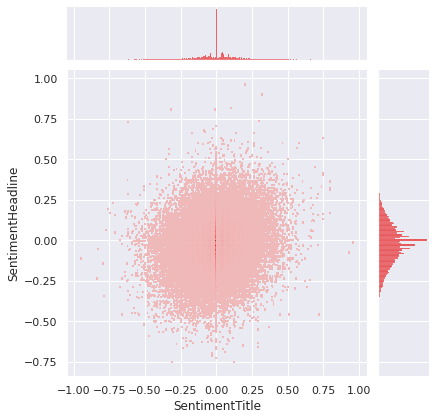

In [ ]:
sns.set(style='darkgrid', palette='Set1')
sns.jointplot(x='SentimentTitle', y='SentimentHeadline', data=df, kind="hist")
plt.show()

*Главная визуализация - это матрица корелляции. Она показывает, насколько признаки похожи и линейно зависимы. Оказывается,  что популярность новостей разная на разных платформах. Также SentimentTitle и SentimentHeadline не кореллируют с популярностью, что значит, что скорее всего они бесполезны.*

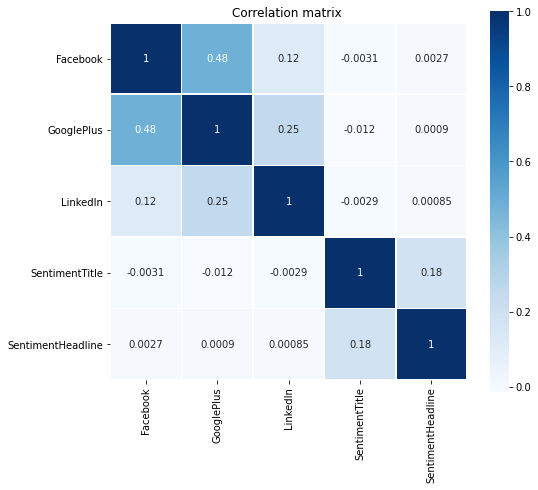

In [36]:
plt.figure(figsize=(8,7))
sns.heatmap(df[(df['Facebook']!=-1) & (df['GooglePlus']!=-1) & (df['LinkedIn']!=-1)]
            [['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), 
            square=True, cmap='Blues',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
plt.show()

*Построение гистограмм целевых переменных. Обязательно в логарифмическом масштабе, потому что слишком велик разброс значений, особенно единичные выбросы в сторону бОльших значений. Логарифмирование позволяет уменьшить интервал значений и сжать большие масштабы.*

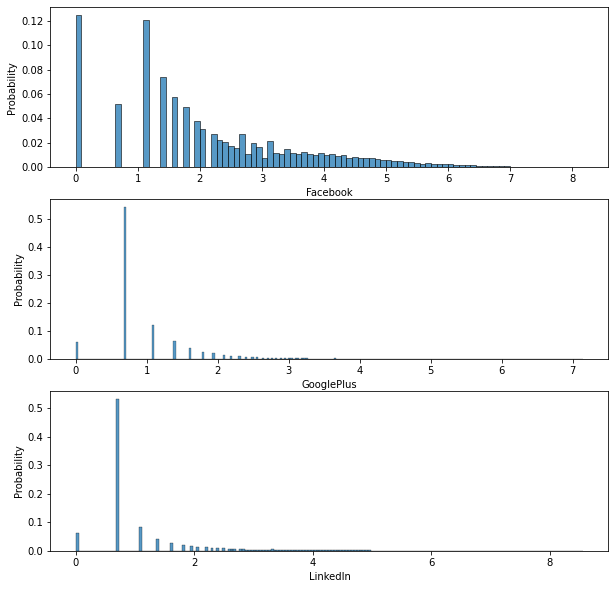

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
sns.histplot(x=np.log(df['Facebook']+2), ax=axes[0], element="bars", stat='probability', legend='Facebook')
sns.histplot(x=np.log(df['GooglePlus']+2), ax=axes[1], element="bars", stat='probability', legend='GooglePlus')
sns.histplot(x=np.log(df['LinkedIn']+2), ax=axes[2], element="bars", stat='probability', legend='LinkedIn')

**е) очистка текста:**

1) перевод в нижний регистр;

2) удаление пунктуации;

3) разбивание текста на слова;

4) удаление стоп-слов (артикли, местоимения, have, is и т.д.);

5) стемминг (удаление окончаний);

6) удалением слов длиной в 1 символ;

7) удаление строк в 1 слово.

In [99]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
def preprocess_text(texts):
    texts = texts.lower() 
    texts = re.sub(r"[^\w\s]", " ", texts)
    splitwords = texts.split()
    splitwords = [stemmer.stem(word) for word in splitwords if word not in set(stopwords.words('english')) and len(word)>1] 
    if len(splitwords):
      texts = " ".join(splitwords)
      return texts
    else:
      return np.nan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Очистка текста выполняется долго.*

In [12]:
%%time
df_text = df.copy()
df_text['Title'] = df_text['Title'].apply(preprocess_text)
df_text['Headline'] = df_text['Headline'].apply(preprocess_text)
df_text.dropna(subset=['Title', 'Headline'], inplace=True)

CPU times: user 6min 30s, sys: 39.9 s, total: 7min 10s
Wall time: 7min 11s


In [14]:
df_text[['Title', 'Headline']].head()

,Title,Headline
0,obama lay wreath arlington nation cemeteri,obama lay wreath arlington nation cemeteri pre...
1,look health chines economi,tim haywood invest director busi unit head fix...
2,nouriel roubini global economi back 2008,nouriel roubini nyu professor chairman roubini...
3,finland gdp expand q4,finland economi expand margin three month end ...
4,tourism govt spend buoy thai economi januari,tourism public spend continu boost economi jan...


*Для спокойного дальнейшего исследования необходимо сохранить данные в отдельный файл, чтобы при необходимости быстро восстановить испорченные данные.*

In [112]:
# df_text.to_csv(drive_data_path+'News_Proc_Text.csv', index = False)

In [ ]:
# df_text= pd.read_csv(drive_data_path+"News_Proc_Text.csv", sep=',', index_col=None)
# df_text.info()

# 2. Инженерия признаков

**а) т.к. обучаем модель только по фейсбуку, имеет смысл в новом датасете выкинуть строки с -1 популярностью. Т.к. это означает отсутствие данных (ссылка на документ о собранных данных https://arxiv.org/pdf/1801.07055.pdf), фактически NaN.**

In [17]:
df_facebook = df_text[df_text['Facebook']>-1].copy()

**б) добавляем новый признак - день недели публикации. В выходной день обычно публикации более читаемые.**

**в) возможно, час публикации поможет в определении популярности новости.**

*Можно добавить и другие признаки: месяц, день месяца, минута публикации, но исходя из логических соображений эти признаки бессмыссленны.*

In [18]:
# df_facebook['PublishDate'] = pd.to_datetime(df_facebook['PublishDate'], format='%Y-%m-%d %H:%M:%S')
df_facebook['DayOfWeek'] = df_facebook['PublishDate'].dt.dayofweek
df_facebook['Hour'] = df_facebook['PublishDate'].dt.hour

*С новыми признаками строим матрицу корелляции. Она показывает незначительную корелляцию, поэтому данные признаки скорее всего полезны.*

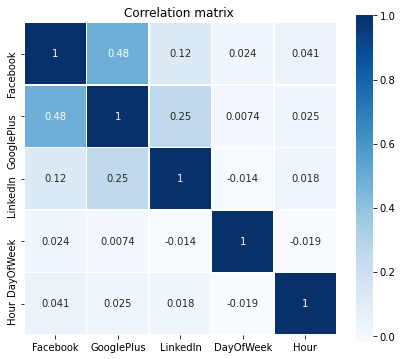

In [19]:
plt.figure(figsize=(7,6))
sns.heatmap(df_facebook[(df_facebook['GooglePlus']!=-1) & (df_facebook['LinkedIn']!=-1)]
            [['Facebook','GooglePlus','LinkedIn','DayOfWeek','Hour']].corr(), 
            square=True, cmap='Blues',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
plt.show()

**г) преобразуем текст в вектор признаков. Также фильтруем список слов по минимальному порогу встречаемости. Было выбрано 2 раза минимальной встречаемости.**

*Считаем количество уникальных слов классом Counter. Считаем количество слов со встречаемостью 2 и более раз, сравниваем с общим количеством: разница в 2 раза. Проверено, что слова, которые встречаются только 1 раз, не имеют лексической ценности для популярности.*


*Преобразуем предложения в векторы признаков классом CounterVectorizer, которые представляют собой столбцы, обозначающие слова, содержащие количество встречаемости слова в предложении. Добавляем параметр ngram - представление самых частых словосочетаний как единое целое. Задаём вручную примерное максимальное количество признаков, чтобы зря не превышать их количество автоматически.*

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
min_freq = 2

results = Counter()
df_facebook['Title'].str.split().apply(results.update)
result_filtered = dict(filter(lambda elem: elem[1]>=min_freq, results.items()))

vectorizer = CountVectorizer(ngram_range=(1,2), max_features=30000, min_df=min_freq)
t_vect = vectorizer.fit_transform(df_facebook['Title'])
print(len(results), '-->', len(result_filtered), '-->', len(vectorizer.vocabulary_))

results = Counter()
df_facebook['Headline'].str.split().apply(results.update)
result_filtered = dict(filter(lambda elem: elem[1]>=min_freq, results.items()))

vectorizer = CountVectorizer(ngram_range=(1,2), max_features=40000, min_df=min_freq)
h_vect = vectorizer.fit_transform(df_facebook['Headline'])
print(len(results), '-->', len(result_filtered), '-->', len(vectorizer.vocabulary_))

20303 --> 12403 --> 30000
32187 --> 18973 --> 40000


**д) преобразование категориальных признаков и 'DayOfWeek', 'Hour' в матрицу методом One-hot-encoding.**

**е) из-за использования текстовых признаков, настроения заголовков должны представлять собой разреженную матрицу. Для этого дескретизируем, деля на части с частотой в 0.01, и делаем матрицу методом One-hot-encoding.**

In [21]:
encode_columns = ['DayOfWeek', 'Hour', 'Source', 'Topic']
dummies = pd.get_dummies(df_facebook[encode_columns], drop_first=True)

t_sent = pd.get_dummies(pd.cut(df_facebook['SentimentTitle'], round((max(df_facebook.SentimentTitle) - min(df_facebook.SentimentTitle))/0.01)))
h_sent = pd.get_dummies(pd.cut(df_facebook['SentimentHeadline'], round((max(df_facebook.SentimentHeadline) - min(df_facebook.SentimentHeadline))/0.01)))

**ж) создание готового датасета для обучения, представляющего собой разреженную матрицу.**

**и) логарифмируем целевую переменную и создаём дополнительную дискретизированную переменную для использования классификатора для текста.**

In [22]:
from scipy.sparse import hstack, csr_matrix
df_prep_train = hstack([t_vect, h_vect, csr_matrix(dummies), csr_matrix(t_sent), csr_matrix(h_sent)])
y_facebook = np.log((df_facebook['Facebook']+1))

delta = 0.01
n_intervals = round(max(y_facebook)/delta)
y_facebook_class =  pd.cut(y_facebook, n_intervals, labels=np.arange(n_intervals))

**Й) разделяем датасет с целевой переменной на обучающую и тестовую выборки.**

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test,  y_facebook_train, y_facebook_test, y_facebook_class_train, y_facebook_class_test = \
  train_test_split(df_prep_train, y_facebook, y_facebook_class, shuffle = True, test_size=0.3)

# 3. Обучение моделей

*Создание функций для оценки качества моделей.* 

*Оценка проводится тремя способами:*


1.   *Средняя абсолютная ошибка - средняя разница между предсказаниями и реальностью.*
2.   *Средняя квадратичная ошибка - средняя разница в квадрате. Помогает выявить наиболее большие ошибки.*

1.   *Средняя среднеквадратичная ошибка - средний квадратный корень из суммы квадратов ошибок. Показывает наиболее отличающиеся ошибки в реальном масштабе в отличие от п.2.*








In [98]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def get_error(test, pred):
  print('mean absolute error:', mean_absolute_error(test, pred))
  print('mean squared error:', mean_squared_error(test, pred))
  print('root mean squared error:', mean_squared_error(test, pred, squared=False))

def get_error_class(test, pred):
  transformed_pred = pred*delta
  get_error(test, transformed_pred)


*Бустинговый регрессор XGBRegressor. Это ансамблевый регрессор, использующий бустинг - обучение каждого эстиматора на части данных. Не подвержен переобучению, обучается быстро. Из-за большого количества данных приблизительно увеличим количество естиматоров и глубину деревьев, чтобы не было недостатка мощности алгоритма.*

In [26]:
%%time
from xgboost import XGBRegressor
xgbr = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr.fit(x_train, y_facebook_train)
xgb_pred = xgbr.predict(x_test)
get_error(y_facebook_test, xgb_pred)

mean absolute error: 0.7167908611683315
mean squared error: 0.7963879577942357
root mean squared error: 0.8924057136718901
CPU times: user 51 s, sys: 49.2 ms, total: 51 s
Wall time: 51.3 s


*Линейная регрессия - мощный регрессор. Ожидаемо, что на таком типе данных она работает слабо. Если настроить гиперпараметры, то возможно, что она покажет лучшие результаты, но обучается очень долго.*

In [42]:
%%time
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_facebook_train)
lr_pred = lr.predict(x_test)
get_error(y_facebook_test, lr_pred)

mean absolute error: 6.064105623622194
mean squared error: 62.44684386613464
root mean squared error: 7.902331546204237
CPU times: user 25min 25s, sys: 17min 57s, total: 43min 23s
Wall time: 22min 2s


*Использование наивного байеса требует дискретизации целевой переменной. Благодаря простому алгориму Байеса он быстро предсказывает 350 классов. Но качество гораздо ниже.*

In [121]:
%%time
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=0.1)
mnb.fit(x_train ,y_facebook_class_train)
mnb_pred = mnb.predict(x_test)
get_error_class(y_facebook_test, mnb_pred)

mean absolute error: 1.0081569837942113
mean squared error: 1.8628234355798292
root mean squared error: 1.3648528988795199
CPU times: user 3.24 s, sys: 5.43 ms, total: 3.24 s
Wall time: 3.25 s


*Использование ансамблевого AdaBoostClassifier. В сравнении с RandomForest он показывает примерно одинаковое качество, но работает гораздо быстрее. AdaBoost и RandomForest регрессоры и RandomForest классификатор очень долго обучаются, поэтому попытка их использовать обернулась неудачей.*

In [122]:
%%time
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(x_train ,y_facebook_class_train)
abc_pred = abc.predict(x_test)
get_error_class(y_facebook_test, abc_pred)

mean absolute error: 1.617176294355913
mean squared error: 4.393889921013933
root mean squared error: 2.0961607574358254
CPU times: user 1min 21s, sys: 39.7 ms, total: 1min 21s
Wall time: 1min 21s


*Лишние признаки не влияют на качество модели из-за её принципа работы. Но их удаление позволяет уменьшить размерность данных, что сказывается на производительности. Тестируем влияние признаков на предсказание модели.*

*Сначала убираем SentimentTitle и SentimentHeadline. Качество не изменилось, значит признаки лишние.* 

In [57]:
df_prep_train = hstack([t_vect, h_vect, csr_matrix(dummies)])
x_train, x_test,  y_facebook_train, y_facebook_test = \
  train_test_split(df_prep_train, y_facebook, shuffle = True, test_size=0.3)

In [58]:
%%time
xgbr = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr.fit(x_train, y_facebook_train)
xgb2_pred = xgbr.predict(x_test)
get_error(y_facebook_test, xgb2_pred)

mean absolute error: 0.7194933878401457
mean squared error: 0.7920895257279704
root mean squared error: 0.8899941155580583
CPU times: user 51.1 s, sys: 93.8 ms, total: 51.2 s
Wall time: 51.3 s


*Пробуем убрать сразу все остальные признаки, оставив только текст. Качество упало, поэтому оставим их.* 

In [55]:
df_prep_train = hstack([t_vect, h_vect])
x_train, x_test,  y_facebook_train, y_facebook_test = \
  train_test_split(df_prep_train, y_facebook, shuffle = True, test_size=0.3)

In [56]:
%%time
xgbr = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr.fit(x_train, y_facebook_train)
xgb3_pred = xgbr.predict(x_test)
get_error(y_facebook_test, xgb3_pred)

mean absolute error: 0.8852834408540055
mean squared error: 1.2328436248657297
root mean squared error: 1.1103349156293922
CPU times: user 47.6 s, sys: 75.6 ms, total: 47.7 s
Wall time: 47.8 s


*Также были рассмотрен шанс использования и других моделей: SVM, KNN. Но из-за особенностей данных и их работы они априори не могут подойти.*

# 4. Оценка выбраной модели

*Используется кросс-валидация для оценки модели. Кросс-валидация необходима для точного оценивания предсказаний алгоритмов.*

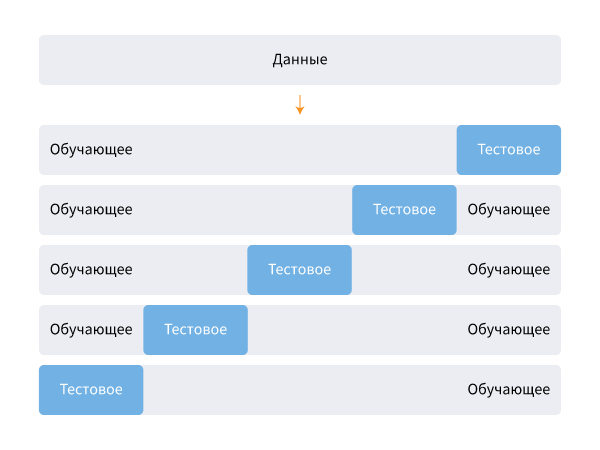

In [29]:
df_prep_train = hstack([t_vect, h_vect, csr_matrix(dummies)])
x_train, x_test,  y_facebook_train, y_facebook_test, y_raw_facebook_train, y_raw_facebook_test = \
  train_test_split(df_prep_train, y_facebook, df_facebook['Facebook'], shuffle = True, test_size=0.3)

*Оценка алгоритма с логарифмированной целевой переменной с помощью кросс-валидации.*

In [30]:
from sklearn.model_selection import cross_validate
results_cv = cross_validate(xgbr, df_prep_train, y_facebook, cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'])
print('Results for log popularity with cv')
print('mean absolute error:', round(-np.mean(results_cv['test_neg_mean_absolute_error']), 3))
print('mean squared error:',  round(-np.mean(results_cv['test_neg_mean_squared_error']), 3))
print('root mean squared error:',  round(-np.mean(results_cv['test_neg_root_mean_squared_error']), 3))

Results for log popularity with cv
mean absolute error: 0.724
mean squared error: 0.807
root mean squared error: 0.898


*Сравнение обычного теста с 30% выборки. Также из логарифма восстанавливаем данные для сравнения производительности с логарифмами и без.*

In [36]:
xgbr = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr.fit(x_train, y_facebook_train)
xgb_pred_test = xgbr.predict(x_test)
print('Results for log popularity without cv')
get_error(y_facebook_test, xgb_pred_test)
print()
print('Results for raw popularity from log without cv')
get_error(np.exp(y_facebook_test)-1, np.exp(xgb_pred_test)-1)

Results for log popularity without cv
mean absolute error: 0.7119144289048411
mean squared error: 0.7804928276694801
root mean squared error: 0.8834550513011288

Results for raw popularity from log without cv
mean absolute error: 26.120771887658375
mean squared error: 8369.25710648567
root mean squared error: 91.48364392876832


*Оценка алгоритма с изначальными сырыми значениями у с помощью кросс-валидации.*

In [74]:
results_cv = cross_validate(xgbr, df_prep_train, df_proceed['Facebook'], cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'])
print('Results for raw popularity with cv')
print('mean absolute error:', round(-np.mean(results_cv['test_neg_mean_absolute_error']), 3))
print('mean squared error:',  round(-np.mean(results_cv['test_neg_mean_squared_error']), 3))
print('root mean squared error:',  round(-np.mean(results_cv['test_neg_root_mean_squared_error']), 3))

Results for raw popularity with cv
mean absolute error: 30.607
mean squared error: 7090.297
root mean squared error: 82.964


*Оценка алгоритма с изначальными сырыми значениями у без помощи кросс-валидации с тестовой выборкой 30%.*

In [37]:
xgbr = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr.fit(x_train, y_raw_facebook_train)
xgb_pred_raw_test = xgbr.predict(x_test)
print('Results for raw popularity without cv')
get_error(y_raw_facebook_test, xgb_pred_raw_test)

Results for raw popularity without cv
mean absolute error: 29.715127134534615
mean squared error: 6691.6900715204
root mean squared error: 81.80275100215395


*График для визуального оценивания отличия предсказанных значений от реальных. Красная линия - идеальное совпадение. Ошибка - разница по горизонтали от точки до линии.*

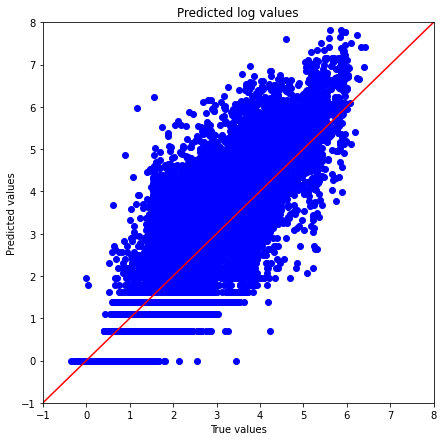

In [39]:
plt.figure(figsize=(7,7))
plt.scatter(xgb_pred_test, y_facebook_test, c='blue')
plt.plot([-1, 8], [-1, 8], c='red')
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.ylim(-1, 8)
plt.xlim(-1, 8)
plt.title('Predicted log values')
plt.show()

*Сравнение двух графиков - использование логарифмирования и не использование. Лучший результат показывает использование сырых данных. Это подтверждает среднеквадратичная ошибка в стравнении разных данных выше.*

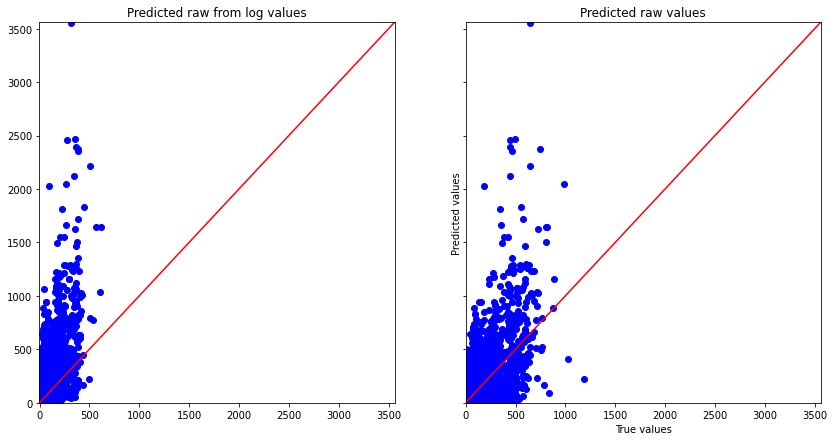

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharex=True, sharey=True)
axes[0].title.set_text('Predicted raw from log values')
axes[0].scatter(np.exp(xgb_pred_test)-1, np.exp(y_facebook_test)-1, c='blue')
axes[0].plot([-1, 3560], [-1, 3560], c='red')
axes[1].title.set_text('Predicted raw values')
axes[1].scatter(xgb_pred_raw_test, y_raw_facebook_test, c='blue')
axes[1].plot([-1, 3560], [-1, 3560], c='red')
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.ylim(-1, 3560)
plt.xlim(-1, 3560)
plt.show()

# 5. Создание итоговых функций для обработки данных с нуля

*Собрание всех дополнительных библиотек в одном месте.*

In [94]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Создание функции для предобработки данных.**

In [95]:
def preprocess(df_raw):
  df_proc = df_raw.copy()
  df_proc.dropna(inplace=True)
  df_proc['PublishDate'] = pd.to_datetime(df_proc['PublishDate'], format='%Y-%m-%d %H:%M:%S')
  df_proc = df_proc.drop_duplicates()

  df_proc['Title'] = df_proc['Title'].apply(preprocess_text)
  df_proc['Headline'] = df_proc['Headline'].apply(preprocess_text)
  df_proc.dropna(subset=['Title', 'Headline'], inplace=True)

  df_proc['DayOfWeek'] = df_proc['PublishDate'].dt.dayofweek
  df_proc['Hour'] = df_proc['PublishDate'].dt.hour

  return df_proc

**Создание функции для выбора целевой переменной и изменения датасета в соответствие с ней.**

In [97]:
def choose_platfom(df_raw, platform):
  df_pl = df_raw[df_raw[platform]>-1].copy()
  df_pl[str(platform+'_log')] = np.log(df_pl[platform]+1)
    return df_pl

**Создание функции для векторизации данных.**

In [54]:
def vectorize(raw_df):
  vectorizer = CountVectorizer(ngram_range=(1,2), max_features=30000, min_df=min_freq)
  t_vect = vectorizer.fit_transform(raw_df['Title'])
  vectorizer = CountVectorizer(ngram_range=(1,2), max_features=40000, min_df=min_freq)
  h_vect = vectorizer.fit_transform(raw_df['Headline'])

  encode_columns = ['DayOfWeek', 'Hour', 'Source', 'Topic']
  dummies = pd.get_dummies(raw_df[encode_columns], drop_first=True)

  df_proc_train = hstack([t_vect, h_vect, csr_matrix(dummies)])
  return df_proc_train

# 6. Тестирование модели на других платформах

*Заново чтение данных и использование функций для проверки их работы.*

In [100]:
df = pd.read_csv(drive_data_path+"News_Final.csv")

In [101]:
df_preprocess = preprocess(df)

df_googlePlus = choose_platfom(df_preprocess, 'GooglePlus')
df_googlePlus_vect = vectorize(df_googlePlus)

df_linkedIn = choose_platfom(df_preprocess, 'LinkedIn')
df_linkedIn_vect = vectorize(df_linkedIn)

df_facebook = choose_platfom(df_preprocess, 'Facebook')
df_facebook_vect = vectorize(df_facebook)

*Получаем оценки предсказаний для каждой социальной сети.*

In [110]:
x_train, x_test,  y_googlePlus_train, y_googlePlus_test = \
  train_test_split(df_googlePlus_vect, df_googlePlus['GooglePlus'], shuffle = True, test_size=0.3)

xgbr_g = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr_g.fit(x_train, y_googlePlus_train)
xgb_g_pred = xgbr_g.predict(x_test)
get_error(y_googlePlus_test, xgb_g_pred)

mean absolute error: 5.210587901480264
mean squared error: 314.6157405144757
root mean squared error: 17.737410761282938


In [103]:
x_train, x_test,  y_linkedIn_train, y_linkedIn_test = \
  train_test_split(df_linkedIn_vect, df_linkedIn['LinkedIn'], shuffle = True, test_size=0.3)

xgbr_l = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr_l.fit(x_train, y_linkedIn_train)
xgb_l_pred = xgbr_g.predict(x_test)
get_error(y_linkedIn_test, xgb_l_pred)

mean absolute error: 17.45480873809802
mean squared error: 8802.55939374004
root mean squared error: 93.82195581920067


In [104]:
x_train, x_test,  y_facebook_train, y_facebook_test = \
  train_test_split(df_facebook_vect, df_facebook['Facebook'], shuffle = True, test_size=0.3)

xgbr_f = XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=200)
xgbr_f.fit(x_train, y_facebook_train)
xgb_f_pred = xgbr_f.predict(x_test)
get_error(y_facebook_test, xgb_f_pred)

mean absolute error: 30.23932305500516
mean squared error: 6171.81943540583
root mean squared error: 78.56092817301632


*График для визуального сравнения результатов.*

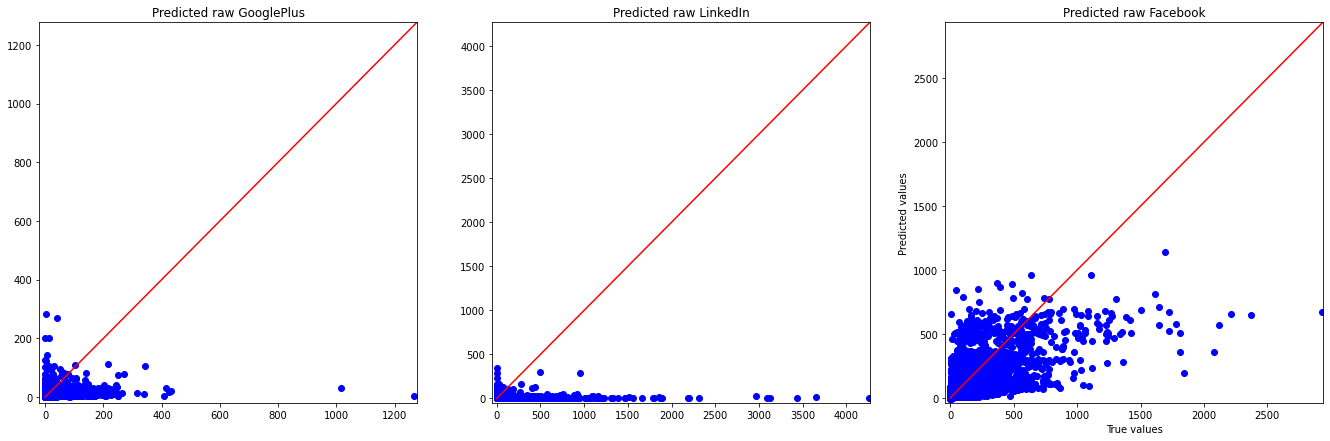

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 7))
max_value = np.amax(y_googlePlus_test) + 10
axes[0].title.set_text('Predicted raw GooglePlus')
axes[0].scatter(y_googlePlus_test, xgb_g_pred, c='blue')
axes[0].plot([-1, max_value], [-1,max_value], c='red')
axes[0].set_xlim(-20, max_value)
axes[0].set_ylim(-20, max_value)

max_value = np.amax(y_linkedIn_test) + 10
axes[1].title.set_text('Predicted raw LinkedIn')
axes[1].scatter(y_linkedIn_test, xgb_l_pred, c='blue')
axes[1].plot([-1, max_value], [-1, max_value], c='red')
axes[1].set_xlim(-50, max_value)
axes[1].set_ylim(-50, max_value)

max_value = np.amax(y_facebook_test) + 10
axes[2].title.set_text('Predicted raw Facebook')
axes[2].scatter(y_facebook_test, xgb_f_pred, c='blue')
axes[2].plot([-1, max_value], [-1, max_value], c='red')
axes[2].set_xlim(-40, max_value)
axes[2].set_ylim(-40, max_value)
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.show()